In [1]:
library(Seurat)
library(data.table)
library(future)
library(future.apply)
library(Matrix)
library(sparseMatrixStats)
library(SingleCellExperiment)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:base’:

    intersect


Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLog

# CIA Vignette

This vignette demonstrates the process of loading gene signatures, calculating signature scores, 
and classifying cells based on these scores using the `CIA.R` script. 
In this example, we will use the CIA method to classify cells from the [Middle Temporal Gyrus (MTG)](https://portal.brain-map.org/atlases-and-data/rnaseq/human-mtg-10x_sea-ad) dataset using publicly available signatures from the [Azimuth Human Motor Cortex](https://azimuth.hubmapconsortium.org/references/#Human%20-%20Motor%20Cortex).

Note: "Chandelier" and "Pax6" cells in the MTG dataset, which are not represented by the Motor Cortex cell type signatures. Since the Azimuth signatures are not meant to distinguish "Chandelier" or "Pax6" cells from the others they have been removed to avoid the misinterpretation of results. We filtered out also cells that don't pass QC, using only cells present in ["AnnData Object (QC'ed data, metadata, and more)"](https://portal.brain-map.org/atlases-and-data/rnaseq/human-mtg-10x_sea-ad).

In [139]:
source('CIA.R')

In [8]:
# To download the dataset. It could take a while (4.78 Gb)
system('wget -O MTG_cia.rds https://sea-ad-single-cell-profiling.s3.us-west-2.amazonaws.com/MTG/RNAseq/Reference_MTG_RNAseq_all-nuclei.2022-06-07.rds')

In [39]:
MTG <- readRDS(file ='MTG_cia.rds')

In [145]:
cat('Old labels:', unique(MTG@meta.data$subclass_label),'\n', '\n')
MTG@meta.data$celltype <- MTG@meta.data$subclass_label
# filter cells
cells <- readRDS('barcodes_after_QC.rds')
MTG <- MTG[,colnames(MTG)%in%cells]

# Rename the specified cell types
MTG@meta.data$celltype <- gsub('Astrocyte', 'Astro', MTG@meta.data$celltype)
MTG@meta.data$celltype <- gsub('Oligodendrocyte', 'Oligo', MTG@meta.data$celltype)
MTG@meta.data$celltype <- gsub('Microglia-PVM', 'Micro-PVM', MTG@meta.data$celltype)
MTG@meta.data$celltype <- gsub('Lamp5 Lhx6', 'Lamp5', MTG@meta.data$celltype)
MTG@meta.data$celltype <- gsub('Endothelial', 'Endo', MTG@meta.data$celltype)
cat('New labels:', unique(MTG@meta.data$celltype))
MTG@meta.data$celltype<- as.factor(MTG@meta.data$celltype)

Idents(MTG)<- MTG@meta.data$celltype


MTG[["umap"]] <- CreateDimReducObject(embeddings = readRDS('umap.rds'), key = "UMAP_")

Old labels: L5/6 NP L5 IT L6 CT Astrocyte L2/3 IT Vip Sst Chodl L6 IT Car3 L6 IT Sncg Pvalb Oligodendrocyte Sst VLMC Lamp5 Microglia-PVM OPC L6b Lamp5 Lhx6 Endothelial L5 ET 
 
New labels: L5/6 NP L5 IT L6 CT Astro L2/3 IT Vip Sst Chodl L6 IT Car3 L6 IT Sncg Pvalb Oligo Sst VLMC Lamp5 Micro-PVM OPC L6b Endo L5 ET

Warning message:
“No assay specified, setting assay as RNA by default.”


In [99]:
MTG <- NormalizeData(MTG, normalization.method = "LogNormalize", scale.factor = 10000)
MTG

An object of class Seurat 
36601 features across 119152 samples within 1 assay 
Active assay: RNA (36601 features, 0 variable features)
 2 layers present: counts, data
 1 dimensional reduction calculated: umap

In [42]:
MTG_SE <- as.SingleCellExperiment(MTG)
MTG_SE

class: SingleCellExperiment 
dim: 36601 119152 
metadata(0):
assays(2): counts logcounts
rownames(36601): MIR1302-2HG FAM138A ... AC007325.4 AC007325.2
rowData names(0):
colnames(119152): AAACCCACACGGTGTC-LKTX_191204_01_A01-1156636525
  AAACCCACACTCTGCT-LKTX_191204_01_A01-1156636525 ...
  TTTGTTGTCATTTGTC-L8TX_200107_01_A09-1156636575
  TTTGTTGTCTGCAGCG-L8TX_200107_01_A09-1156636575
colData names(44): orig.ident nCount_RNA ... celltype ident
reducedDimNames(0):
mainExpName: RNA
altExpNames(0):

In [144]:
levels(MTG@meta.data$celltype)

NULL

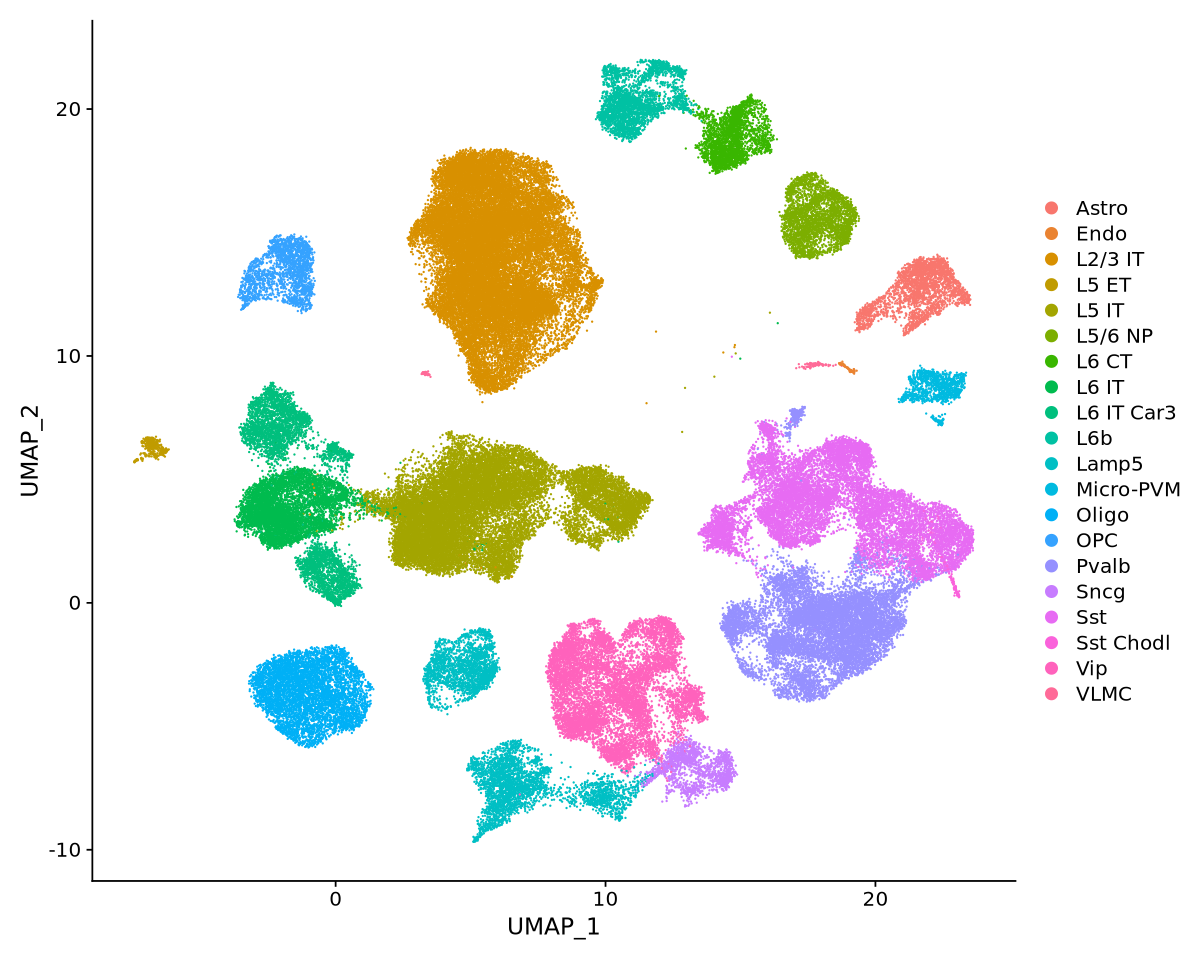

In [146]:
options(repr.plot.width=10, repr.plot.height=8)
DimPlot(MTG, raster=F)

## Loading Gene Signatures

The `load_signatures` function is used to load gene signatures from a TSV file or a named list. 
Each signature consists of a name and a set of associated genes.

In [102]:
gmt <- load_signatures('azimuth_human_motor_cortex.gmt')
gmt

$Astro
 [1] "SLC1A2"     "ADGRV1"     "SLC1A3"     "GPC5"       "RNF219.AS1"
 [6] "ARHGAP24"   "CST3"       "HPSE2"      "AQP4"       "COL5A3"    

$Endo
 [1] "EBF1"   "ABCG2"  "CLDN5"  "FLI1"   "LEF1"   "EMCN"   "IFI27"  "HLA.E" 
 [9] "ADGRL4" "CLEC3B"

$`L2/3 IT`
 [1] "CBLN2"     "EPHA6"     "LAMA2"     "CNTN5"     "PDZD2"     "CUX2"     
 [7] "RASGRF2"   "FAM19A1"   "LINC01378" "CA10"     

$`L5 ET`
 [1] "COL5A2"    "FAM19A1"   "VAT1L"     "COL24A1"   "CBLN2"     "NRP1"     
 [7] "PTCHD1.AS" "NRG1"      "HOMER1"    "SLC35F3"  

$`L5 IT`
 [1] "FSTL4"    "CNTN5"    "RORB"     "FSTL5"    "IL1RAPL2" "CHN2"    
 [7] "TOX"      "CPNE4"    "CADPS2"   "POU6F2"  

$`L5/6 NP`
 [1] "TSHZ2"     "NPSR1.AS1" "HTR2C"     "ITGA8"     "ZNF385D"   "ASIC2"    
 [7] "CDH6"      "CRYM"      "NXPH2"     "CPNE4"    

$`L6 CT`
 [1] "ADAMTSL1" "KIAA1217" "SORCS1"   "HS3ST4"   "TRPM3"    "TOX"     
 [7] "SEMA3E"   "EGFEM1P"  "MEIS2"    "SEMA5A"  

$`L6 IT`
 [1] "PTPRK"    "PDZRN4"   "CDH9"     "THEMIS"   "FSTL5"    "CDH13"   
 [7] "CDH12"    "CBLN2"    "LY86.AS1" "MLIP"    

$`L6 IT Car3`
 [1] "THEMIS"  "RNF152"  "NTNG2"   "STK32B"  "KCNMB2"  "GAS2L3"  "OLFML2B"
 [8] "POSTN"   "B3GAT2"  "NR4A2"  

$L6b
 [1] "HS3ST4"   "KCNMB2"   "MDFIC"    "C10orf11" "NTM"      "CDH9"    
 [7] "MARCH1"   "TLE4"     "FOXP2"    "KIAA1217"

$Lamp5
 [1] "FGF13"   "PTPRT"   "PRELID2" "GRIA4"   "RELN"    "PTCHD4"  "EYA4"   
 [8] "MYO16"   "FBXL7"   "LAMP5"  

$`Micro-PVM`
 [1] "DOCK8"   "P2RY12"  "APBB1IP" "FYB"     "PTPRC"   "TBXAS1"  "CX3CR1" 
 [8] "BLNK"    "SLCO2B1" "CSF1R"  

$Oligo
 [1] "PLP1"    "ST18"    "CTNNA3"  "MBP"     "MOBP"    "RNF220"  "NCKAP5" 
 [8] "ENPP2"   "QKI"     "SLC44A1"

$OPC
 [1] "VCAN"    "PDGFRA"  "OLIG1"   "SMOC1"   "COL9A1"  "STK32A"  "BCAS1"  
 [8] "FERMT1"  "BCHE"    "ZCCHC24"

$Pvalb
 [1] "ADAMTS17" "ERBB4"    "DPP10"    "ZNF804A"  "MYO16"    "BTBD11"  
 [7] "GRIA4"    "SLIT2"    "SDK1"     "PVALB"   

$Sncg
 [1] "CNR1"   "SLC8A1" "ASIC2"  "CXCL14" "MAML3"  "ADARB2" "NPAS3"  "CNTN5" 
 [9] "FSTL5"  "SNCG"  

$Sst
 [1] "GRIK1"      "RALYL"      "SST"        "TRHDE"      "GRID2"     
 [6] "NXPH1"      "COL25A1"    "SLC8A1"     "SOX6"       "ST6GALNAC5"

$`Sst Chodl`
 [1] "NPY"      "FAM46A"   "STAC"     "OTOF"     "NPY2R"    "CRHBP"   
 [7] "ANKRD34B" "NOS1"     "SST"      "CHODL"   

$Vip
 [1] "GALNTL6" "LRP1B"   "VIP"     "GRM7"    "KCNT2"   "THSD7A"  "ERBB4"  
 [8] "SYNPR"   "ADARB2"  "SLC24A3"

$VLMC
 [1] "COLEC12" "ITIH5"   "COL1A2"  "TBX18"   "EBF1"    "C7"      "COL6A2" 
 [8] "SRPX2"   "FLVCR2"  "FMO2"

## Computing Signature Scores

The `compute_signature_scores` function calculates the signature scores based on gene expression data. 
It evaluates the expression level of each gene within individual cells, facilitating the quantification 
of gene set activities across the dataset. This function accepts as input a gene-by-cell expression matrix, 
a `SeuratObject`, or a `SingleCellExperiment`. For `SeuratObject` and `SingleCellExperiment`, 
the specific matrix of interest (like raw counts, normalized data, etc.) can be selected for analysis.


In [103]:
scores <- compute_signature_scores(data = MTG, seurat_assay = 'RNA', matrix = 'data', geneset = gmt$Astro)
head(scores)

AAACCCACACGGTGTC-LKTX_191204_01_A01-1156636525 
                                   0.001503118 
AAACCCACACTCTGCT-LKTX_191204_01_A01-1156636525 
                                   0.000726728 
AAACCCACATCAGCAT-LKTX_191204_01_A01-1156636525 
                                   0.000235930 
AAACGAAAGCACTAAA-LKTX_191204_01_A01-1156636525 
                                   0.048374514 
AAACGAACACAAATGA-LKTX_191204_01_A01-1156636525 
                                   0.002056917 
AAACGAACACGCTGCA-LKTX_191204_01_A01-1156636525 
                                   0.001385323

In [104]:
scores <- compute_signature_scores(data = MTG_SE, matrix = 'logcounts', geneset = gmt$Astro)
head(scores)

AAACCCACACGGTGTC-LKTX_191204_01_A01-1156636525 
                                   0.001503118 
AAACCCACACTCTGCT-LKTX_191204_01_A01-1156636525 
                                   0.000726728 
AAACCCACATCAGCAT-LKTX_191204_01_A01-1156636525 
                                   0.000235930 
AAACGAAAGCACTAAA-LKTX_191204_01_A01-1156636525 
                                   0.048374514 
AAACGAACACAAATGA-LKTX_191204_01_A01-1156636525 
                                   0.002056917 
AAACGAACACGCTGCA-LKTX_191204_01_A01-1156636525 
                                   0.001385323

## Calculating Signature Scores Across a Dataset

The `signature_score` function calculates the signature scores across all given signatures and cells, 
utilizing parallel processing to enhance efficiency. It can compute either raw or transformed scores, based on the specified parameters. 
When working with `SeuratObject` and `SingleCellExperiment`, the function automatically updates the objects by adding the calculated scores into their respective `meta.data` and `colData` slots.


In [53]:
options(future.globals.maxSize = 10 * 1024^3)  # Increase to 10 GiB, adjust according to your needs

In [54]:
MTG <- signature_score(data = MTG, signatures_input = gmt, return_score = F, score_mode = 'scaled',n_cpus =10)


Checking if genes are in the dataset matrix... 
Astro: 9 / 10 
Endo: 9 / 10 
L2/3 IT: 9 / 10 
L5 ET: 8 / 10 
L5 IT: 10 / 10 
L5/6 NP: 9 / 10 
L6 CT: 9 / 10 
L6 IT: 9 / 10 
L6 IT Car3: 10 / 10 
L6b: 9 / 10 
Lamp5: 10 / 10 
Micro-PVM: 9 / 10 
Oligo: 10 / 10 
OPC: 10 / 10 
Pvalb: 10 / 10 
Sncg: 10 / 10 
Sst: 10 / 10 
Sst Chodl: 9 / 10 
Vip: 10 / 10 
VLMC: 10 / 10 
Scores have been added in data@meta.data 


In [55]:
head(MTG@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA,specimen_name,sample_name,donor_sex_label,external_donor_name_label,species_label,age_label,region_label,⋯,Lamp5,Micro-PVM,Oligo,OPC,Pvalb,Sncg,Sst,Sst Chodl,Vip,VLMC
,<fct>,<dbl>,<int>,<chr>,<chr>,<fct>,<fct>,<fct>,<fct>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AAACCCACACGGTGTC-LKTX_191204_01_A01-1156636525,SeuratProject,20295,6607,AAACCCACACGGTGTC-LKTX_191204_01_A01-1156636525,AAACCCACACGGTGTC-LKTX_191204_01_A01-1156636525,M,H18.30.002,Homo Sapiens,50 yrs,MTG,⋯,0.02516749,0.0008987261,0.01303011,0.001149168,0.05386745,0.07942385,0.04953801,0.000000000,0.10411520,0
AAACCCACACTCTGCT-LKTX_191204_01_A01-1156636525,SeuratProject,34116,8569,AAACCCACACTCTGCT-LKTX_191204_01_A01-1156636525,AAACCCACACTCTGCT-LKTX_191204_01_A01-1156636525,M,H18.30.002,Homo Sapiens,50 yrs,MTG,⋯,0.03992587,0.0005564294,0.02614109,0.000000000,0.06212487,0.16259539,0.13900600,0.006475482,0.07578032,0
AAACCCACATCAGCAT-LKTX_191204_01_A01-1156636525,SeuratProject,25121,7075,AAACCCACATCAGCAT-LKTX_191204_01_A01-1156636525,AAACCCACATCAGCAT-LKTX_191204_01_A01-1156636525,M,H18.30.002,Homo Sapiens,50 yrs,MTG,⋯,0.02615830,0.0000000000,0.02218943,0.000000000,0.12090840,0.16625664,0.07247863,0.002768604,0.05806877,0
AAACGAAAGCACTAAA-LKTX_191204_01_A01-1156636525,SeuratProject,6545,2971,AAACGAAAGCACTAAA-LKTX_191204_01_A01-1156636525,AAACGAAAGCACTAAA-LKTX_191204_01_A01-1156636525,M,H18.30.002,Homo Sapiens,50 yrs,MTG,⋯,0.04916056,0.0000000000,0.03828361,0.005226543,0.09276117,0.05213673,0.11452964,0.000000000,0.09802700,0
AAACGAACACAAATGA-LKTX_191204_01_A01-1156636525,SeuratProject,26036,6264,AAACGAACACAAATGA-LKTX_191204_01_A01-1156636525,AAACGAACACAAATGA-LKTX_191204_01_A01-1156636525,M,H18.30.002,Homo Sapiens,50 yrs,MTG,⋯,0.08710917,0.0000000000,0.01874875,0.001031094,0.03084114,0.12098500,0.14259002,0.001678896,0.07590312,0
AAACGAACACGCTGCA-LKTX_191204_01_A01-1156636525,SeuratProject,43755,8580,AAACGAACACGCTGCA-LKTX_191204_01_A01-1156636525,AAACGAACACGCTGCA-LKTX_191204_01_A01-1156636525,M,H18.30.002,Homo Sapiens,50 yrs,MTG,⋯,0.07676481,0.0000000000,0.02608999,0.000000000,0.13566712,0.14387109,0.11740540,0.000000000,0.10905793,0


In [56]:
MTG_SE <- signature_score(data = MTG_SE, signatures_input = gmt, return_score = F, score_mode = 'scaled',n_cpus =10)

Checking if genes are in the dataset matrix... 
Astro: 9 / 10 
Endo: 9 / 10 
L2/3 IT: 9 / 10 
L5 ET: 8 / 10 
L5 IT: 10 / 10 
L5/6 NP: 9 / 10 
L6 CT: 9 / 10 
L6 IT: 9 / 10 
L6 IT Car3: 10 / 10 
L6b: 9 / 10 
Lamp5: 10 / 10 
Micro-PVM: 9 / 10 
Oligo: 10 / 10 
OPC: 10 / 10 
Pvalb: 10 / 10 
Sncg: 10 / 10 
Sst: 10 / 10 
Sst Chodl: 9 / 10 
Vip: 10 / 10 
VLMC: 10 / 10 
Scores have been added in colData(data) 


In [57]:
head(data.frame(colData(MTG_SE)))

,orig.ident,nCount_RNA,nFeature_RNA,specimen_name,sample_name,donor_sex_label,external_donor_name_label,species_label,age_label,region_label,⋯,Lamp5,Micro.PVM,Oligo,OPC,Pvalb,Sncg,Sst,Sst.Chodl,Vip,VLMC
,<fct>,<dbl>,<int>,<chr>,<chr>,<fct>,<fct>,<fct>,<fct>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AAACCCACACGGTGTC-LKTX_191204_01_A01-1156636525,SeuratProject,20295,6607,AAACCCACACGGTGTC-LKTX_191204_01_A01-1156636525,AAACCCACACGGTGTC-LKTX_191204_01_A01-1156636525,M,H18.30.002,Homo Sapiens,50 yrs,MTG,⋯,0.02516749,0.0008987261,0.01303011,0.001149168,0.05386745,0.07942385,0.04953801,0.000000000,0.10411520,0
AAACCCACACTCTGCT-LKTX_191204_01_A01-1156636525,SeuratProject,34116,8569,AAACCCACACTCTGCT-LKTX_191204_01_A01-1156636525,AAACCCACACTCTGCT-LKTX_191204_01_A01-1156636525,M,H18.30.002,Homo Sapiens,50 yrs,MTG,⋯,0.03992587,0.0005564294,0.02614109,0.000000000,0.06212487,0.16259539,0.13900600,0.006475482,0.07578032,0
AAACCCACATCAGCAT-LKTX_191204_01_A01-1156636525,SeuratProject,25121,7075,AAACCCACATCAGCAT-LKTX_191204_01_A01-1156636525,AAACCCACATCAGCAT-LKTX_191204_01_A01-1156636525,M,H18.30.002,Homo Sapiens,50 yrs,MTG,⋯,0.02615830,0.0000000000,0.02218943,0.000000000,0.12090840,0.16625664,0.07247863,0.002768604,0.05806877,0
AAACGAAAGCACTAAA-LKTX_191204_01_A01-1156636525,SeuratProject,6545,2971,AAACGAAAGCACTAAA-LKTX_191204_01_A01-1156636525,AAACGAAAGCACTAAA-LKTX_191204_01_A01-1156636525,M,H18.30.002,Homo Sapiens,50 yrs,MTG,⋯,0.04916056,0.0000000000,0.03828361,0.005226543,0.09276117,0.05213673,0.11452964,0.000000000,0.09802700,0
AAACGAACACAAATGA-LKTX_191204_01_A01-1156636525,SeuratProject,26036,6264,AAACGAACACAAATGA-LKTX_191204_01_A01-1156636525,AAACGAACACAAATGA-LKTX_191204_01_A01-1156636525,M,H18.30.002,Homo Sapiens,50 yrs,MTG,⋯,0.08710917,0.0000000000,0.01874875,0.001031094,0.03084114,0.12098500,0.14259002,0.001678896,0.07590312,0
AAACGAACACGCTGCA-LKTX_191204_01_A01-1156636525,SeuratProject,43755,8580,AAACGAACACGCTGCA-LKTX_191204_01_A01-1156636525,AAACGAACACGCTGCA-LKTX_191204_01_A01-1156636525,M,H18.30.002,Homo Sapiens,50 yrs,MTG,⋯,0.07676481,0.0000000000,0.02608999,0.000000000,0.13566712,0.14387109,0.11740540,0.000000000,0.10905793,0


In [58]:
# Set the plot width to 10 inches and height to 6 inches
options(repr.plot.width=16, repr.plot.height=6)

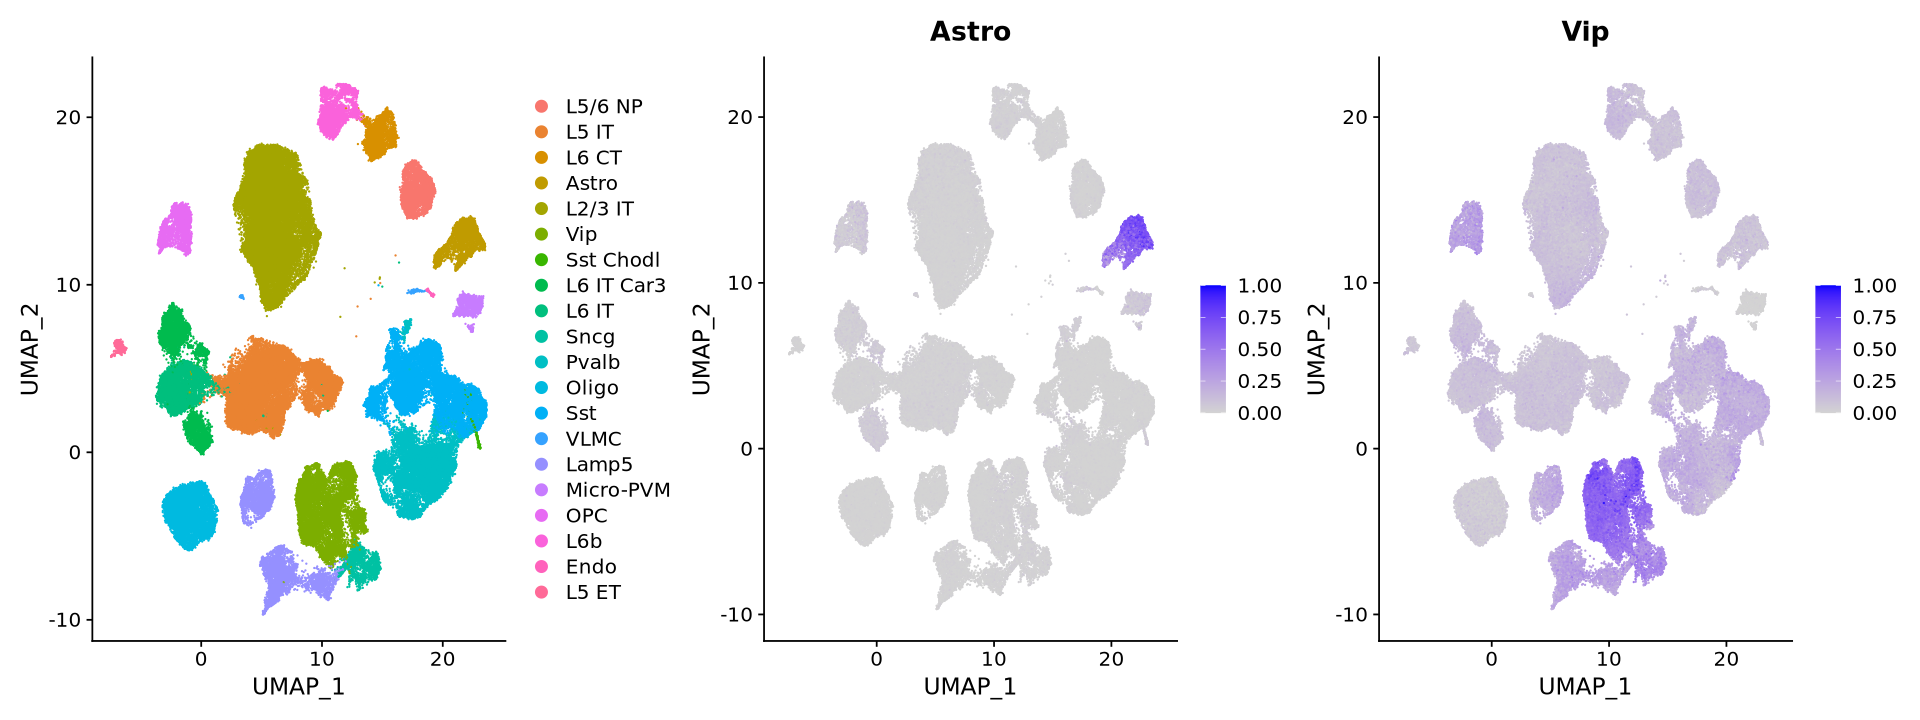

In [59]:
DimPlot(MTG, raster=F)|FeaturePlot(MTG,features = 'Astro', raster=F)|FeaturePlot(MTG,features = 'Vip', raster=F)

## Classification Based on Signature Scores

Using the `signature_based_classification` function, cells are classified based on their signature scores. 
The function determines the most representative gene signature for each cell, 
which aids in the phenotypic characterization of the cells.


In [105]:
MTG<-signature_based_classification(data = MTG, signatures_input = gmt,n_cpus =40,similarity_threshold = 0)

Checking if genes are in the dataset matrix... 
Astro: 9 / 10 
Endo: 9 / 10 
L2/3 IT: 9 / 10 
L5 ET: 8 / 10 
L5 IT: 10 / 10 
L5/6 NP: 9 / 10 
L6 CT: 9 / 10 
L6 IT: 9 / 10 
L6 IT Car3: 10 / 10 
L6b: 9 / 10 
Lamp5: 10 / 10 
Micro-PVM: 9 / 10 
Oligo: 10 / 10 
OPC: 10 / 10 
Pvalb: 10 / 10 
Sncg: 10 / 10 
Sst: 10 / 10 
Sst Chodl: 9 / 10 
Vip: 10 / 10 
VLMC: 10 / 10 

Classification complete!    Start: 16:11:58     End: 16:12:31 
CIA_prediction has been added in data@meta.data 


In [61]:
head(MTG@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA,specimen_name,sample_name,donor_sex_label,external_donor_name_label,species_label,age_label,region_label,⋯,Micro-PVM,Oligo,OPC,Pvalb,Sncg,Sst,Sst Chodl,Vip,VLMC,CIA_prediction
,<fct>,<dbl>,<int>,<chr>,<chr>,<fct>,<fct>,<fct>,<fct>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
AAACCCACACGGTGTC-LKTX_191204_01_A01-1156636525,SeuratProject,20295,6607,AAACCCACACGGTGTC-LKTX_191204_01_A01-1156636525,AAACCCACACGGTGTC-LKTX_191204_01_A01-1156636525,M,H18.30.002,Homo Sapiens,50 yrs,MTG,⋯,0.0008987261,0.01303011,0.001149168,0.05386745,0.07942385,0.04953801,0.000000000,0.10411520,0,L5/6 NP
AAACCCACACTCTGCT-LKTX_191204_01_A01-1156636525,SeuratProject,34116,8569,AAACCCACACTCTGCT-LKTX_191204_01_A01-1156636525,AAACCCACACTCTGCT-LKTX_191204_01_A01-1156636525,M,H18.30.002,Homo Sapiens,50 yrs,MTG,⋯,0.0005564294,0.02614109,0.000000000,0.06212487,0.16259539,0.13900600,0.006475482,0.07578032,0,L5 IT
AAACCCACATCAGCAT-LKTX_191204_01_A01-1156636525,SeuratProject,25121,7075,AAACCCACATCAGCAT-LKTX_191204_01_A01-1156636525,AAACCCACATCAGCAT-LKTX_191204_01_A01-1156636525,M,H18.30.002,Homo Sapiens,50 yrs,MTG,⋯,0.0000000000,0.02218943,0.000000000,0.12090840,0.16625664,0.07247863,0.002768604,0.05806877,0,L6 CT
AAACGAAAGCACTAAA-LKTX_191204_01_A01-1156636525,SeuratProject,6545,2971,AAACGAAAGCACTAAA-LKTX_191204_01_A01-1156636525,AAACGAAAGCACTAAA-LKTX_191204_01_A01-1156636525,M,H18.30.002,Homo Sapiens,50 yrs,MTG,⋯,0.0000000000,0.03828361,0.005226543,0.09276117,0.05213673,0.11452964,0.000000000,0.09802700,0,Astro
AAACGAACACAAATGA-LKTX_191204_01_A01-1156636525,SeuratProject,26036,6264,AAACGAACACAAATGA-LKTX_191204_01_A01-1156636525,AAACGAACACAAATGA-LKTX_191204_01_A01-1156636525,M,H18.30.002,Homo Sapiens,50 yrs,MTG,⋯,0.0000000000,0.01874875,0.001031094,0.03084114,0.12098500,0.14259002,0.001678896,0.07590312,0,L5 IT
AAACGAACACGCTGCA-LKTX_191204_01_A01-1156636525,SeuratProject,43755,8580,AAACGAACACGCTGCA-LKTX_191204_01_A01-1156636525,AAACGAACACGCTGCA-LKTX_191204_01_A01-1156636525,M,H18.30.002,Homo Sapiens,50 yrs,MTG,⋯,0.0000000000,0.02608999,0.000000000,0.13566712,0.14387109,0.11740540,0.000000000,0.10905793,0,L5 ET


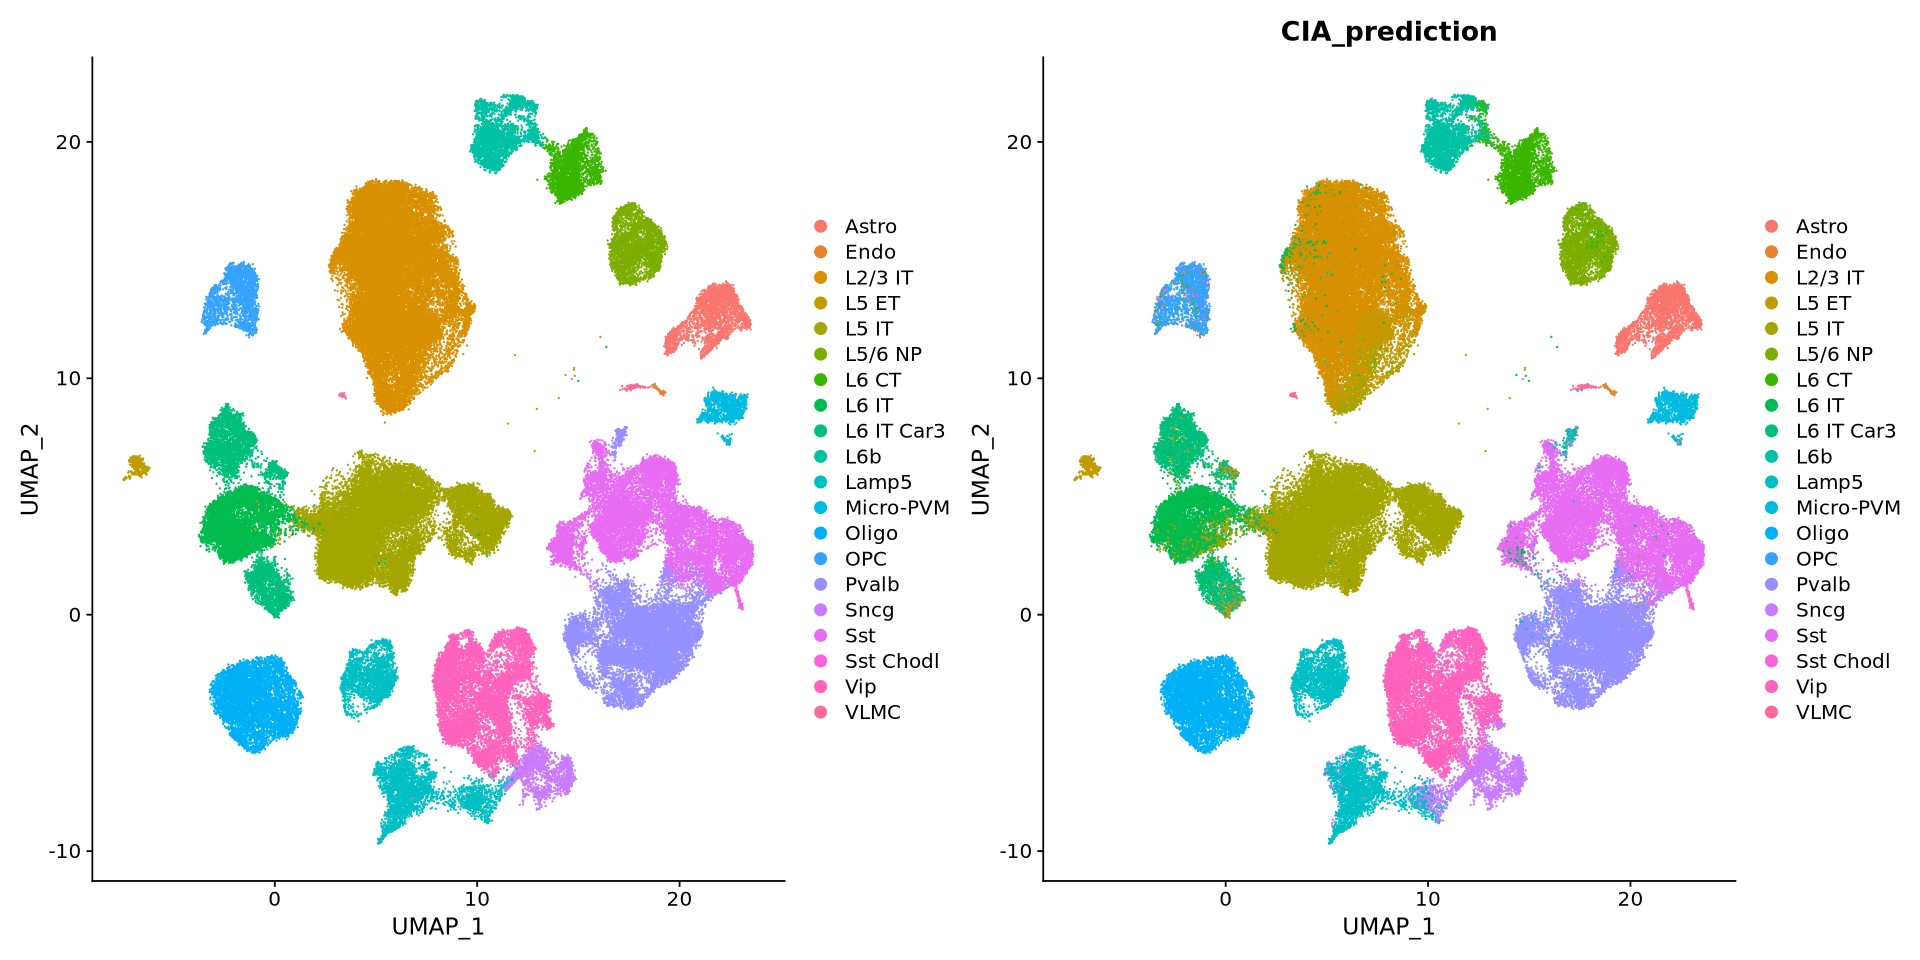

In [147]:
options(repr.plot.width=16, repr.plot.height=8)
DimPlot(MTG, raster=F)| DimPlot(MTG, raster=F,group.by = 'CIA_prediction')

To evaluate the performance and relevance of the classification, the `compute_metrics` function can be used. This function calculates classification metrics such as sensitivity (SE), specificity (SP), precision (PR), accuracy (ACC), and F1-score (F1) for given classification results

In [120]:
compute_metrics(MTG@meta.data, classification_col =  c('CIA_prediction'), groups_cols = 'celltype')

SE        SP        PR       ACC        F1 
0.9266987 0.9961420 0.9266987 0.9926699 0.9266987

## Applying Similarity Threshold

The similarity threshold is a critical parameter in the classification process, utilized within the `signature_based_classification` function. It sets the minimum required difference between the highest and second-highest signature scores for a cell to be confidently classified into a specific category. This threshold prevents ambiguous classifications and ensures that cells are distinctly assigned to the most appropriate categories based on their signature expression levels.

Cells whose signature scores do not meet this threshold are labeled as 'Unassigned'. This label indicates that these cells do not exhibit a strong correlation with any of the predefined signatures, thus avoiding misclassification.

To demonstrate the efficacy of this threshold, we removed the "Astro" signature, anticipating that astrocytes would not be identified thereafter. 

In [122]:
gmt$Astro <-NULL

In [123]:
MTG<-signature_based_classification(data = MTG, signatures_input = gmt,n_cpus =10,similarity_threshold = 0.1,
                                    column_name = "CIA_prediction_t=0.1" )

Checking if genes are in the dataset matrix... 
Endo: 9 / 10 
L2/3 IT: 9 / 10 
L5 ET: 8 / 10 
L5 IT: 10 / 10 
L5/6 NP: 9 / 10 
L6 CT: 9 / 10 
L6 IT: 9 / 10 
L6 IT Car3: 10 / 10 
L6b: 9 / 10 
Lamp5: 10 / 10 
Micro-PVM: 9 / 10 
Oligo: 10 / 10 
OPC: 10 / 10 
Pvalb: 10 / 10 
Sncg: 10 / 10 
Sst: 10 / 10 
Sst Chodl: 9 / 10 
Vip: 10 / 10 
VLMC: 10 / 10 

Classification complete!    Start: 16:30:47     End: 16:31:19 
CIA_prediction_t=0.1 has been added in data@meta.data 


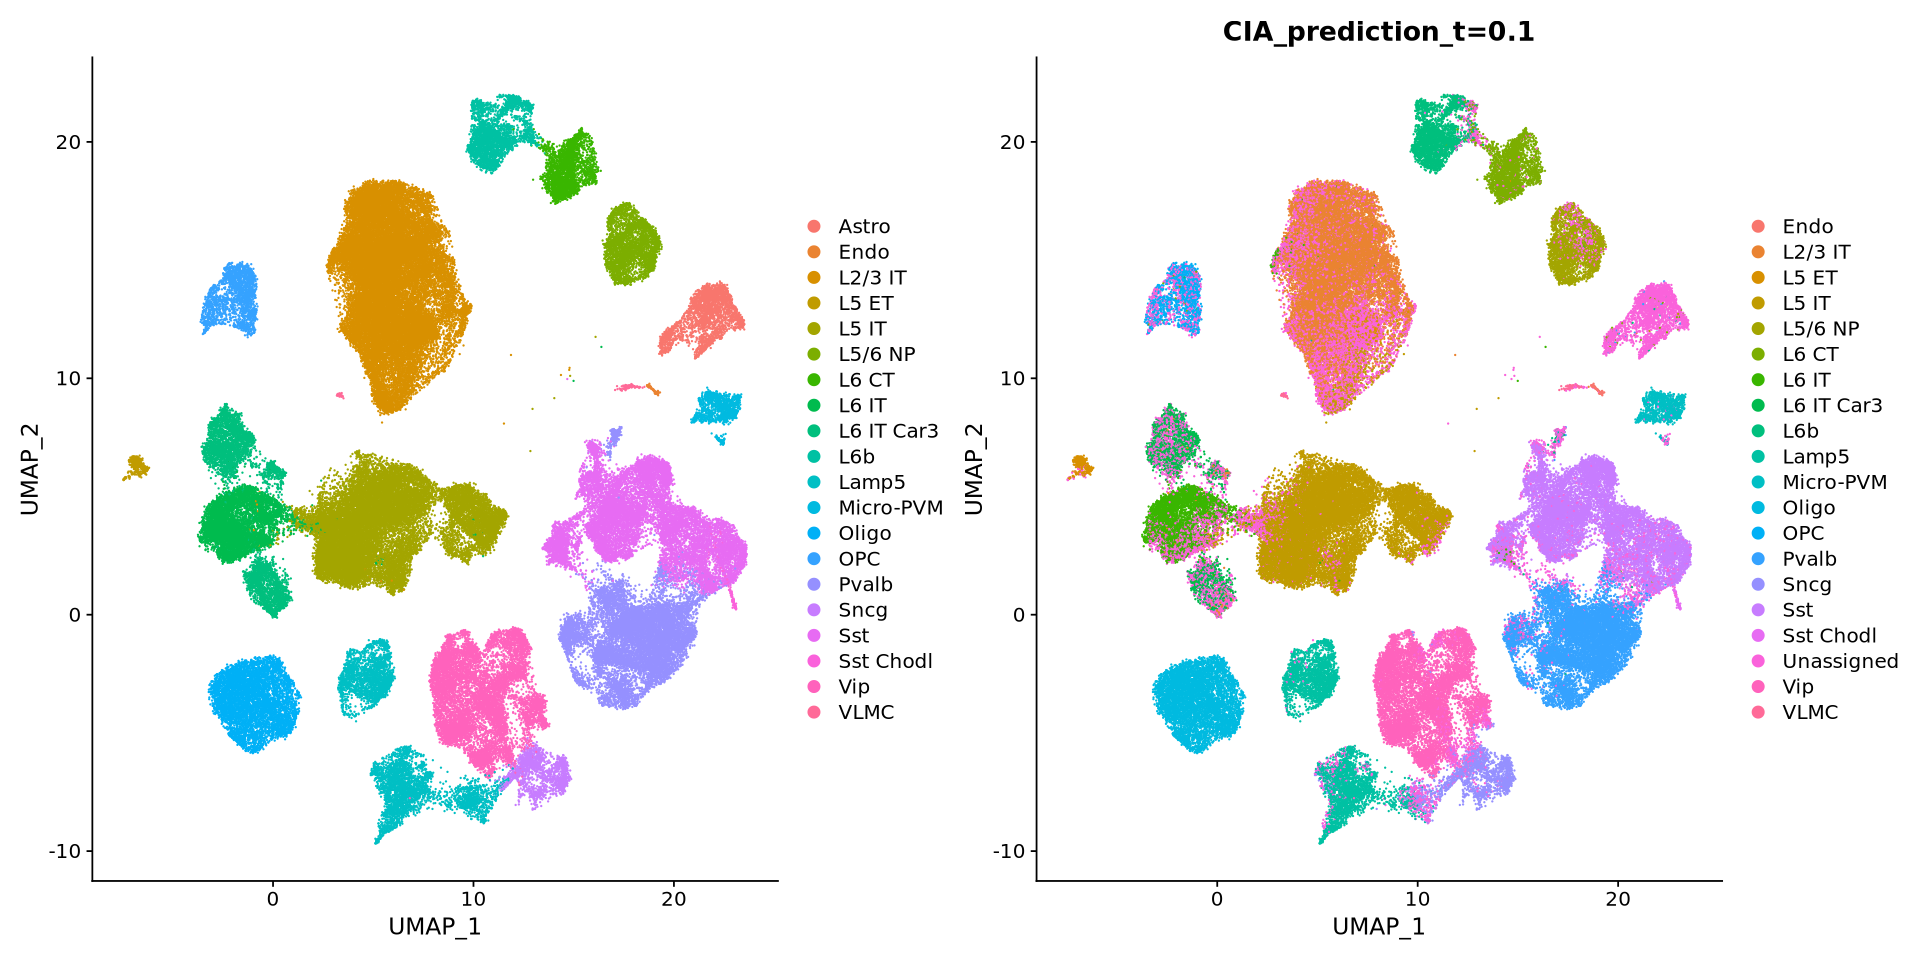

In [148]:
options(repr.plot.width=16, repr.plot.height=8)
DimPlot(MTG, raster=F)| DimPlot(MTG, raster=F,group.by = 'CIA_prediction_t=0.1')

As expected, all the astrocytes, along with any cells previously misclassified, are now labeled as 'Unassigned'. This outcome confirms the importance of setting an appropriate similarity threshold to enhance the classification's accuracy and reliability.

In [141]:
# considering unassigned as 'misclassified'
compute_metrics(MTG@meta.data,  classification_col = c('CIA_prediction','CIA_prediction_t=0.1'), groups_cols = 'celltype')


# removing unassigned from metrics calculation
compute_metrics(MTG@meta.data,  classification_col = c('CIA_prediction','CIA_prediction_t=0.1'), groups_cols = 'celltype',
               unassigned_label='Unassigned')

,SE,SP,PR,ACC,F1
CIA_prediction,0.9266987,0.9961420,0.9266987,0.9926699,0.9266987
CIA_prediction_t.0.1,0.8031758,0.9989558,0.9758933,0.9891668,0.8811506


,SE,SP,PR,ACC,F1,%UN
CIA_prediction,0.9266987,0.9961420,0.9266987,0.9926699,0.9266987,0.0
CIA_prediction_t.0.1,0.9758933,0.9987312,0.9758933,0.9975893,0.9758933,17.7


# Conclusion

In this vignette, we covered how to load gene signatures, compute signature scores, and classify cells 
based on those scores. These processes are key to analyzing and understanding gene expression patterns 
in single-cell RNA-seq data, providing insights into the cellular heterogeneity of the samples.
